In [8]:
import numpy as np
from collections import defaultdict
from itertools import permutations
import random
import csv
import matplotlib.pyplot as plt
import networkx as nx

# Q-Learning Path Finder with Visualization

This notebook demonstrates the implementation of a Q-Learning based pathfinding algorithm. The algorithm learns the shortest paths in a network through reinforcement learning, systematically exploring all possible paths.

## Objectives
- Understand the mathematical background behind Q-Learning.
- Implement Q-Learning for pathfinding in a network.
- Visualize the network and the learned paths.
- Analyze the training process and performance.


## Mathematical Background

### Q-Learning Algorithm
Q-Learning is a model-free reinforcement learning algorithm to learn the value of an action in a particular state. The agent explores the environment, updates its knowledge using the following formula:

$ Q(s, a) \leftarrow Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right] $

Where:
- $Q(s, a)$ is the current estimate of the Q-value for state $s$ and action $a$.
- $\alpha$ is the learning rate.
- $r$ is the reward received after taking action $a$ from state $s$.
- $gamma$ is the discount factor, determining the importance of future rewards.
- $\max_{a'} Q(s', a')$ is the maximum estimated Q-value for the next state $s'$.

### Pathfinding
In the context of pathfinding, the states represent nodes in the network, actions represent moving from one node to another, and the rewards are negative distances (as we seek to minimize the path length).

### Exploration vs. Exploitation
The algorithm balances exploration (choosing random actions) and exploitation (choosing the best-known actions) using the epsilon-greedy strategy:

$\epsilon_{new} = \max(\epsilon_{min}, \epsilon \cdot \epsilon_{decay})$


In [9]:
class EnhancedQLearningPathFinder:
    def __init__(self, learning_rate=0.1, discount_factor=0.99, initial_epsilon=1.0, min_epsilon=0.01, epsilon_decay=0.995):
        self.q_table = defaultdict(lambda: defaultdict(lambda: 0))
        self.best_paths = {}
        self.best_distances = {}
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.initial_epsilon = initial_epsilon
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.graph = defaultdict(list)
        self.all_paths = {}


        self.episode_rewards = []
        self.episode_lengths = []
        self.epsilon_values = []

    def add_edge(self, source, destination, distance):

        self.graph[source].append((destination, distance))
        self.graph[destination].append((source, distance))

    def find_all_possible_paths(self, start, end, path=None, distance=0):

        if path is None:
            path = []

        path = path + [start]

        if start == end:
            return [(path, distance)]

        paths = []
        for next_node, dist in self.graph[start]:
            if next_node not in path:
                new_paths = self.find_all_possible_paths(next_node, end, path, distance + dist)
                paths.extend(new_paths)

        return paths

    def calculate_all_paths(self):

        nodes = list(self.graph.keys())
        for start, end in permutations(nodes, 2):
            paths = self.find_all_possible_paths(start, end)
            if paths:

                paths.sort(key=lambda x: x[1])
                self.all_paths[(start, end)] = paths

                self.best_paths[(start, end)] = paths[0][0]
                self.best_distances[(start, end)] = paths[0][1]

    def get_shortest_theoretical_path(self, start, end):
        return self.best_paths.get((start, end))

    def choose_action(self, state, available_actions, end_state):
        if not available_actions:
            return None

        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)


        if (state, end_state) in self.best_paths:
            best_path = self.best_paths[(state, end_state)]
            current_index = best_path.index(state)
            if current_index < len(best_path) - 1:
                next_in_best_path = best_path[current_index + 1]
                if next_in_best_path in available_actions:
                    return next_in_best_path


        q_values = {action: self.q_table[state][action] for action in available_actions}
        max_q = max(q_values.values())
        actions_with_max_q = [action for action, q_value in q_values.items() if np.isclose(q_value, max_q)]
        return np.random.choice(actions_with_max_q)

    def get_distance(self, state, next_state):
        for dest, dist in self.graph[state]:
            if dest == next_state:
                return dist
        return float('inf')

    def train_systematically(self, episodes_per_pair=1000, max_steps_per_episode=100):
        self.calculate_all_paths()

        nodes = list(self.graph.keys())
        node_pairs = list(permutations(nodes, 2))

        for start, end in node_pairs:
            self.epsilon = self.initial_epsilon

            for episode in range(episodes_per_pair):
                current_state = start
                visited = {current_state}
                path_distance = 0
                total_reward = 0
                episode_length = 0

                for step in range(max_steps_per_episode):
                    available_actions = [node for node, _ in self.graph[current_state] if node not in visited]

                    if not available_actions:
                        break

                    next_state = self.choose_action(current_state, available_actions, end)
                    if next_state is None:
                        break

                    distance = self.get_distance(current_state, next_state)
                    optimal_distance = self.best_distances.get((start, end), float('inf'))

                    reward = -distance
                    if (start, end) in self.best_paths:
                        if next_state in self.best_paths[(start, end)]:
                            reward += 50

                    if next_state == end:
                        if path_distance + distance <= optimal_distance:
                            reward += 200
                        else:
                            reward += 100

                    next_available_actions = [node for node, _ in self.graph[next_state] if node not in visited]
                    next_q_values = [self.q_table[next_state][next_action] for next_action in next_available_actions]
                    next_max_q = max(next_q_values) if next_q_values else 0

                    old_q = self.q_table[current_state][next_state]
                    new_q = (1 - self.learning_rate) * old_q + \
                            self.learning_rate * (reward + self.discount_factor * next_max_q)
                    self.q_table[current_state][next_state] = new_q

                    current_state = next_state
                    visited.add(current_state)
                    path_distance += distance
                    total_reward += reward
                    episode_length += 1

                    if current_state == end:
                        break

                self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

                self.episode_rewards.append(total_reward)
                self.episode_lengths.append(episode_length)
                self.epsilon_values.append(self.epsilon)

    def find_shortest_path(self, start, end):
        if start not in self.graph or end not in self.graph:
            return None, float('inf')

        if (start, end) in self.best_paths:
            path = self.best_paths[(start, end)]
            distance = self.best_distances[(start, end)]
            return path, distance

        current_state = start
        path = [current_state]
        visited = {current_state}
        total_distance = 0

        while current_state != end:
            available_actions = [node for node, _ in self.graph[current_state] if node not in visited]

            if not available_actions:
                return None, float('inf')

            q_values = {action: self.q_table[current_state][action] for action in available_actions}

            if not q_values:
                return None, float('inf')

            next_state = max(q_values, key=q_values.get)
            distance = self.get_distance(current_state, next_state)

            current_state = next_state
            path.append(current_state)
            visited.add(current_state)
            total_distance += distance

            if current_state == end:
                break

        return path, total_distance

    def visualize_network(self):
        G = nx.Graph()
        for node in self.graph:
            for neighbor, distance in self.graph[node]:
                G.add_edge(node, neighbor, weight=distance)

        pos = nx.spring_layout(G)
        edge_labels = nx.get_edge_attributes(G, 'weight')

        plt.figure(figsize=(12, 8))
        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.title("Network Graph")
        plt.show()

    def visualize_path(self, start, end, path):
        if path is None:
            print(f"No path found from {start} to {end}")
            return

        G = nx.Graph()
        for node in self.graph:
            for neighbor, distance in self.graph[node]:
                G.add_edge(node, neighbor, weight=distance)

        pos = nx.spring_layout(G, iterations=50)

        nx.draw_networkx_edges(G, pos, edge_color='gray', width=1)

        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels)

        nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)

        nx.draw_networkx_labels(G, pos)

        if path:
            path_edges = list(zip(path[:-1], path[1:]))
            nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
            nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='r', node_size=500)

        plt.title(f"Path from {start} to {end}")
        plt.show()

    def plot_analysis(self):


        plt.figure(figsize=(12, 6))
        plt.plot(self.episode_rewards, label='Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Rewards per Episode')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.episode_lengths, label='Episode Lengths', color='orange')
        plt.xlabel('Episode')
        plt.ylabel('Length')
        plt.title('Episode Lengths over Time')
        plt.legend()
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(self.epsilon_values, label='Epsilon Values', color='green')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.title('Epsilon Decay over Time')
        plt.legend()
        plt.show()


## Analysis and Explanation

### Training Process
- The Q-learning agent is trained systematically by exploring all possible pairs of nodes in the network.
- For each pair, the agent explores the network for a specified number of episodes, updating its Q-values based on the rewards received.
- The rewards are designed to encourage the agent to find the shortest paths, with additional bonuses for following known optimal paths and reaching the goal.

### Visualization
- The initial network graph is visualized before training to provide an overview of the network structure.
- After training, the shortest path found by the Q-learning agent is visualized on the graph, highlighting the path taken.
- The training process is analyzed by plotting the rewards per episode, episode lengths, and the decay of the epsilon value over time.

### Performance
- The agent's performance is measured by the total rewards received and the lengths of the episodes.
- The decay of the epsilon value indicates the balance between exploration and exploitation during training.
- The visualizations help to understand the efficiency of the learned paths and the agent's learning process.

By following this notebook, you can gain a comprehensive understanding of the Q-learning algorithm, its implementation for pathfinding, and the analysis of its performance in a network environment.


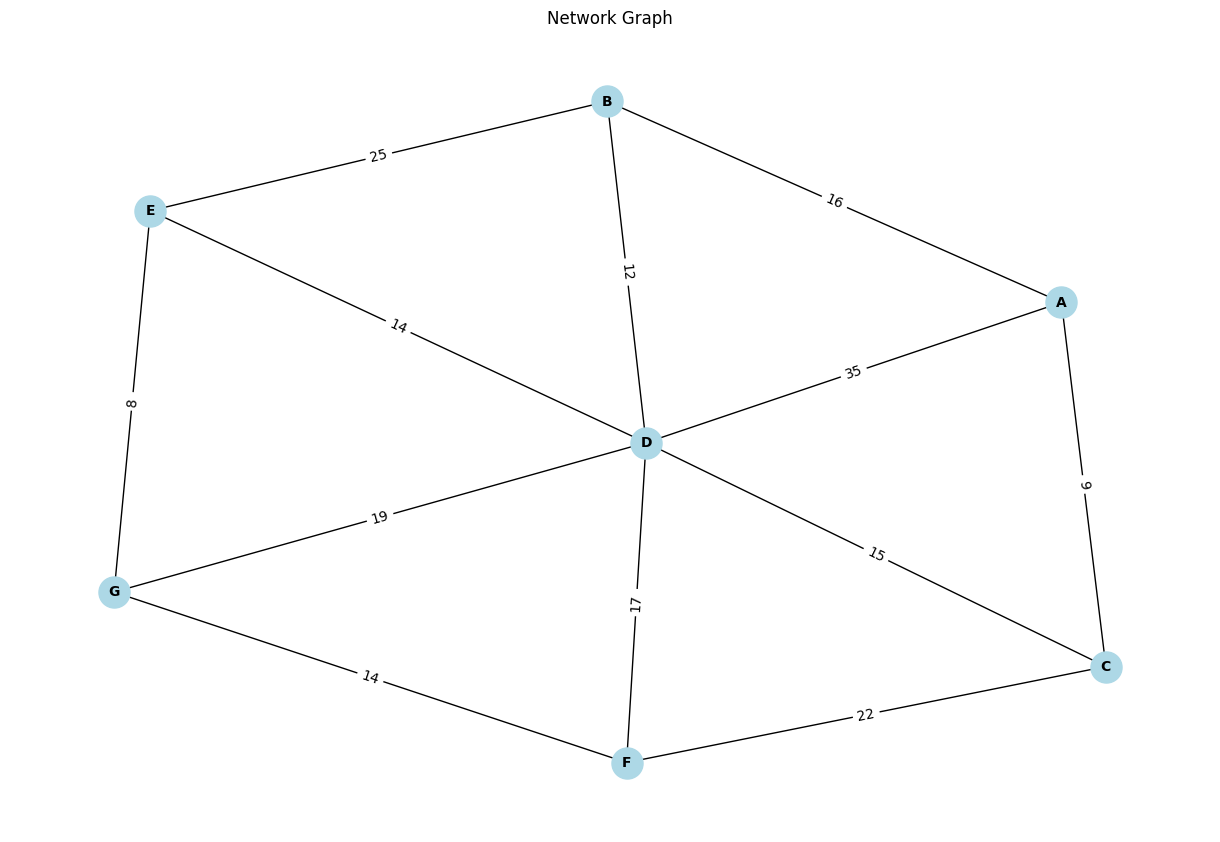

Enter the starting node: A
Enter the ending node: G
Shortest path from A to G: ['A', 'C', 'D', 'G'] with total distance 43


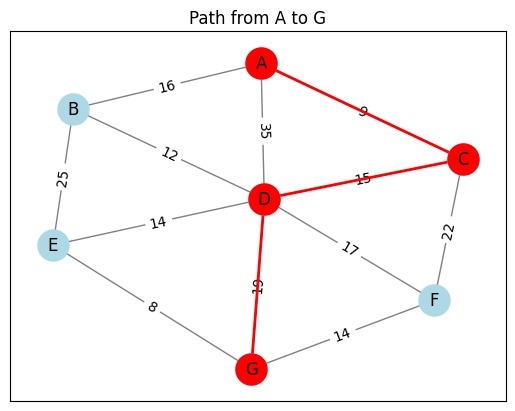

In [10]:
path_finder = EnhancedQLearningPathFinder()

csv_file = 'edges.csv'
with open(csv_file, mode='r') as file:
    csv_reader = csv.DictReader(file)
    for row in csv_reader:
        source = row['source']
        dest = row['destination']
        distance = int(row['distance'])
        path_finder.add_edge(source, dest, distance)

path_finder.visualize_network()

path_finder.train_systematically(episodes_per_pair=500, max_steps_per_episode=50)

start_node = input("Enter the starting node: ").strip()
end_node = input("Enter the ending node: ").strip()

shortest_path, total_distance = path_finder.find_shortest_path(start_node, end_node)
print(f"Shortest path from {start_node} to {end_node}: {shortest_path} with total distance {total_distance}")
path_finder.visualize_path(start_node, end_node, shortest_path)

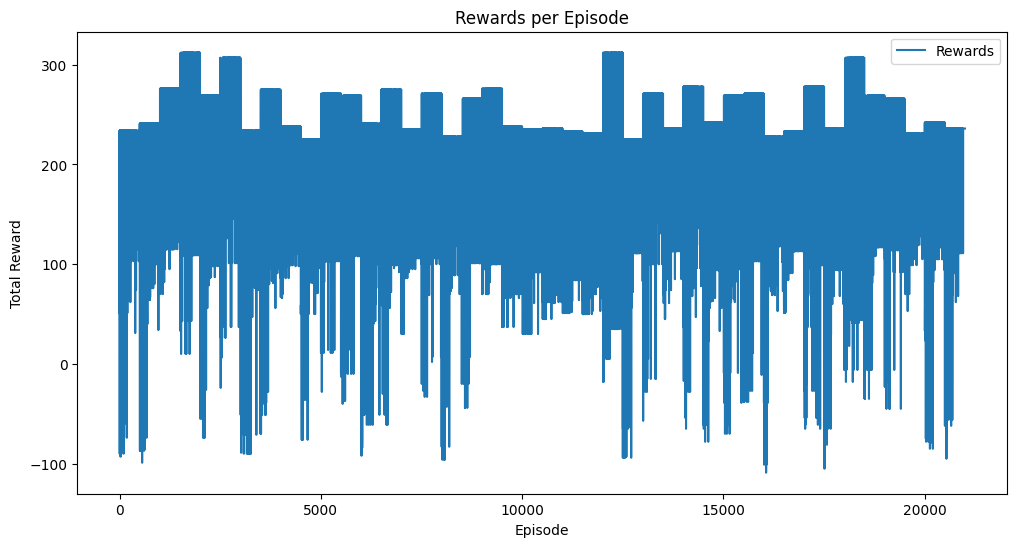

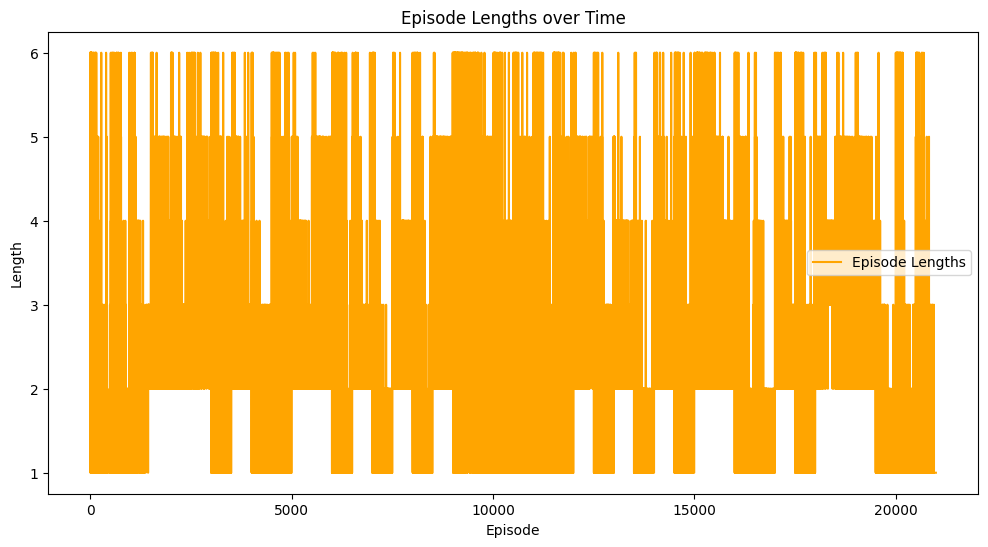

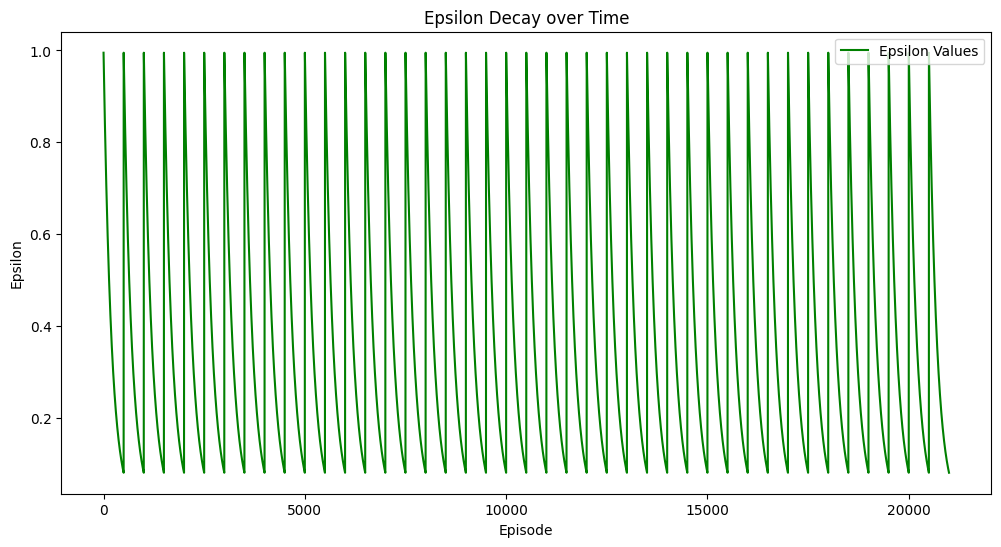

In [11]:
path_finder.plot_analysis()